## Import PuLP package

In [65]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# pulp.pulpTestAll()

## Define Constant

割引クーポンによるマーケティングキャンペーンの最適化

- customers.csv             :顧客情報
- visit_probability.csv     :キャンペーン毎の顧客来店確率
- キャンペーンの種類は1.メール、2.メール＋1000円割引クーポン、3.メール＋2000円割引クーポンの3種類

In [3]:
customer_df = pd.read_csv('customers.csv')
visit_prob_df = pd.read_csv('visit_probability.csv')

In [4]:
customer_df.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [5]:
customer_df.shape

(5000, 3)

In [11]:
customer_df.apply(set)

customer_id    {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
age_cat                     {age20~34, age35~49, age50~, age~19}
freq_cat                           {freq3~, freq2, freq0, freq1}
dtype: object

In [13]:
visit_prob_df.head()

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37


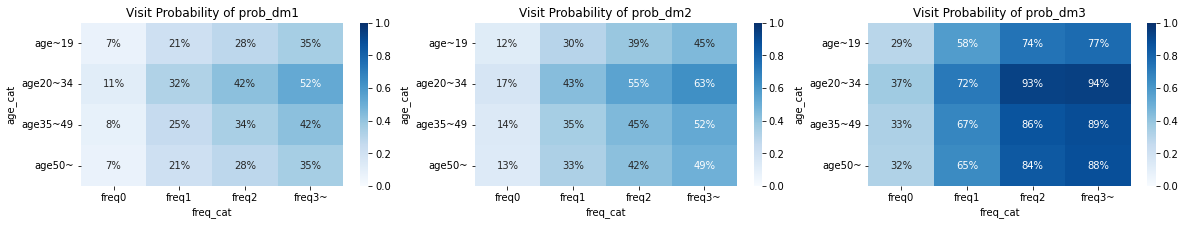

In [24]:
fig, axes = plt.subplots(1,3, figsize=(20,3))
for i, prob in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    visit_prob_pivot = pd.pivot_table(visit_prob_df, prob, index='age_cat', columns=['freq_cat'] )
    visit_prob_pivot = visit_prob_pivot.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(visit_prob_pivot, ax=axes[i], vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues')
    axes[i].set_title(f'Visit Probability of {prob}')
plt.show()

In [17]:
#顧客のリスト
I = customer_df['customer_id'].to_list()
#クーポンのリスト
M = [ 1, 2, 3]

## Create Variable

生徒sをクラスcに割り当てる場合に1, そうでない場合に0とする
(s, c) タプルのリスト

In [25]:
IM = [(i,m) for i in I for m in M]

In [34]:
# 0-1整数計画問題の場合 binary
# x = pulp.LpVariable.dicts('x', IM, cat='Binary')

xim={}
for i in I:
    for m in M:
        xim[i,m] = pulp.LpVariable(f'xim({i},{m})', cat='Binary')

In [37]:
xim[1,1]

xim(1,1)

In [38]:
len(xim)

15000

In [42]:
cus_prob_df = pd.merge(customer_df, visit_prob_df, on=['age_cat', 'freq_cat'])
cus_prob_df.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93


In [50]:
cust_prob_ver_df = cus_prob_df.rename(columns={'prob_dm1':1 , 'prob_dm2':2, 'prob_dm3':3}).melt(id_vars=['customer_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
cust_prob_ver_df.head()

,customer_id,dm,prob
0,1,1,0.42
1,199,1,0.42
2,200,1,0.42
3,255,1,0.42
4,269,1,0.42


In [54]:
Pim = cust_prob_ver_df.set_index(['customer_id', 'dm'])['prob'].to_dict()
Pim[1,1]

0.42

## Create Model

- `LpProblem('name', sense=LpMinimize or LpMaximize)

In [40]:
prob = pulp.LpProblem('DiscountCouponProblem1', pulp.LpMaximize)

## Create Constraint

In [41]:
# (2) 各会員に送るダイレクトメールはいずれか１つ
for i in I:
    prob += pulp.lpSum([xim[i, m] for m in M]) == 1

In [56]:
# クーポン金額
Cm = { 1: 0, 2:1000, 3:2000}

In [58]:
# (4) 顧客の消費する費用の期待値の合計値は100万円以下
prob += pulp.lpSum(xim[i, m] * Cm[m] * Pim[i, m] for i in I for m in [2,3]) <= 1000000

In [60]:
S = visit_prob_df['segment_id'].to_list()
S

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [62]:
Ns = cus_prob_df.groupby(['segment_id'])['customer_id'].count().to_dict()
Ns

{1: 200,
 2: 150,
 3: 50,
 4: 100,
 5: 600,
 6: 450,
 7: 150,
 8: 300,
 9: 800,
 10: 600,
 11: 200,
 12: 400,
 13: 400,
 14: 300,
 15: 100,
 16: 200}

In [63]:
Si = cus_prob_df.set_index('customer_id')['segment_id'].to_dict()
Si

{1: 7,
 199: 7,
 200: 7,
 255: 7,
 269: 7,
 319: 7,
 399: 7,
 426: 7,
 456: 7,
 459: 7,
 511: 7,
 575: 7,
 577: 7,
 642: 7,
 648: 7,
 673: 7,
 699: 7,
 703: 7,
 720: 7,
 747: 7,
 751: 7,
 787: 7,
 797: 7,
 847: 7,
 852: 7,
 902: 7,
 922: 7,
 976: 7,
 1026: 7,
 1069: 7,
 1118: 7,
 1131: 7,
 1197: 7,
 1202: 7,
 1211: 7,
 1264: 7,
 1275: 7,
 1404: 7,
 1453: 7,
 1490: 7,
 1501: 7,
 1505: 7,
 1520: 7,
 1559: 7,
 1579: 7,
 1592: 7,
 1629: 7,
 1650: 7,
 1735: 7,
 1748: 7,
 1891: 7,
 1892: 7,
 1929: 7,
 1932: 7,
 1933: 7,
 2021: 7,
 2053: 7,
 2059: 7,
 2139: 7,
 2164: 7,
 2194: 7,
 2206: 7,
 2255: 7,
 2303: 7,
 2313: 7,
 2364: 7,
 2388: 7,
 2425: 7,
 2571: 7,
 2603: 7,
 2604: 7,
 2651: 7,
 2700: 7,
 2707: 7,
 2714: 7,
 2746: 7,
 2762: 7,
 2801: 7,
 2885: 7,
 2920: 7,
 2923: 7,
 3011: 7,
 3037: 7,
 3045: 7,
 3075: 7,
 3097: 7,
 3146: 7,
 3174: 7,
 3192: 7,
 3209: 7,
 3214: 7,
 3218: 7,
 3224: 7,
 3225: 7,
 3323: 7,
 3372: 7,
 3388: 7,
 3392: 7,
 3415: 7,
 3454: 7,
 3518: 7,
 3599: 7,
 3603: 7,


In [64]:
# (5) セグメントに属する会員数の10%以上に送付
for s in S:
    for m in M:
        prob += pulp.lpSum(xim[i,m] for i in I if Si[i] == s) >= 0.1 * Ns[s]

## Create Target function

In [55]:
# 来客数の増加数を最大化
prob += pulp.lpSum((Pim[i, m]-Pim[i,1]) * xim[i, m] for i in I for m in [2,3])

## Exec Solver

- Default solver is CBC. You can use GLPK if installed.

In [67]:
time_start = time.time()
status = prob.solve()
time_stop = time.time()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/norihito/workspace/optimization-problems/.venv/lib/python3.8/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/c5b124cd52284464bb5fc655037701c1-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/c5b124cd52284464bb5fc655037701c1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5054 COLUMNS
At line 85055 RHS
At line 90105 BOUNDS
At line 105106 ENDATA
Problem MODEL has 5049 rows, 15000 columns and 40000 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 326.095 - 0.20 seconds
Cgl0004I processed model has 5049 rows, 15000 columns (15000 integer (15000 of which binary)) and 40000 elements
Cutoff increment increased from 1e-05 to 0.00999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.156863
Cbc0038I Pass   1: (0.45 seconds) suminf.    0.12500 (2) obj. -326.

KeyboardInterrupt: 

4600 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (1704.46 seconds)
Cbc0010I After 164700 nodes, 102997 on tree, -326.06 best solution, best possible -326.0951 (1705.77 seconds)
Cbc0010I After 164800 nodes, 102989 on tree, -326.06 best solution, best possible -326.0951 (1707.13 seconds)
Cbc0010I After 164900 nodes, 103025 on tree, -326.06 best solution, best possible -326.0951 (1707.90 seconds)
Cbc0010I After 165000 nodes, 103016 on tree, -326.06 best solution, best possible -326.0951 (1708.97 seconds)
Cbc0010I After 165100 nodes, 103033 on tree, -326.06 best solution, best possible -326.0951 (1709.92 seconds)
Cbc0010I After 165200 nodes, 103014 on tree, -326.06 best solution, best possible -326.0951 (1711.04 seconds)
Cbc0010I After 165300 nodes, 103012 on tree, -326.06 best solution, best possible -326.0951 (1712.12 seconds)
Cbc0010I After 165400 nodes, 103018 on tree, -326.06 best solution, best possible -326.0951 (1713.32 seconds)
Cbc0010I After 165500 nodes

## Check status

- You can check the status by `LpStatus` which shows 
    {0: 'Not Solved', 1: 'Optimal', -1:'Infeasible', -2: 'Unbounded', -3: 'Undefined'}

In [ ]:
pulp.LpStatus

{0: 'Not Solved',
 1: 'Optimal',
 -1: 'Infeasible',
 -2: 'Unbounded',
 -3: 'Undefined'}

In [ ]:
pulp.LpStatus[prob.status]
# pulp.LpStatus[status]

'Optimal'

## Result 

In [ ]:
print(f'目的関数値: {prob.objective.value():.4}')
print(f'計算時間:{(time_stop-time_start):.3}(秒)')

Class:  A
Num:  40
Student:  [2, 16, 17, 19, 21, 26, 27, 75, 76, 78, 85, 97, 100, 105, 121, 129, 139, 149, 161, 165, 169, 189, 196, 202, 213, 215, 240, 243, 246, 252, 253, 254, 256, 264, 267, 270, 275, 278, 279, 300]

Class:  B
Num:  40
Student:  [1, 11, 33, 36, 37, 40, 54, 55, 61, 63, 65, 73, 82, 101, 106, 118, 143, 145, 148, 150, 153, 157, 163, 171, 176, 187, 194, 207, 208, 210, 211, 220, 247, 248, 276, 286, 287, 297, 308, 313]

Class:  C
Num:  39
Student:  [3, 8, 23, 30, 32, 41, 48, 52, 56, 67, 69, 77, 83, 102, 103, 122, 131, 134, 138, 154, 155, 162, 178, 184, 209, 214, 224, 228, 235, 236, 242, 255, 265, 269, 274, 288, 289, 294, 316]

Class:  D
Num:  39
Student:  [14, 20, 22, 35, 43, 45, 49, 62, 70, 71, 87, 88, 89, 96, 99, 107, 112, 113, 119, 132, 133, 146, 166, 183, 191, 192, 197, 201, 212, 216, 234, 245, 262, 273, 280, 283, 302, 303, 309]

Class:  E
Num:  40
Student:  [6, 9, 15, 31, 39, 42, 46, 53, 60, 64, 108, 110, 111, 124, 141, 142, 144, 151, 156, 159, 160, 170, 173, 186, 204, 

## Verification

In [92]:
result_df = s_df.copy()
result_df.head()

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class
0,1,0,0,0,335,109.0,F
1,2,1,0,0,379,38.0,G
2,3,0,0,0,350,79.0,H
3,4,0,0,0,301,172.0,E
4,5,1,0,0,317,147.0,D


In [93]:
S2C = {s:c for s in S for c in C if x[s,c].value() == 1}

In [94]:
result_df['assigned_class'] = result_df['student_id'].map(S2C)
result_df.head()

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class,assigned_class
0,1,0,0,0,335,109.0,F,B
1,2,1,0,0,379,38.0,G,A
2,3,0,0,0,350,79.0,H,C
3,4,0,0,0,301,172.0,E,H
4,5,1,0,0,317,147.0,D,G


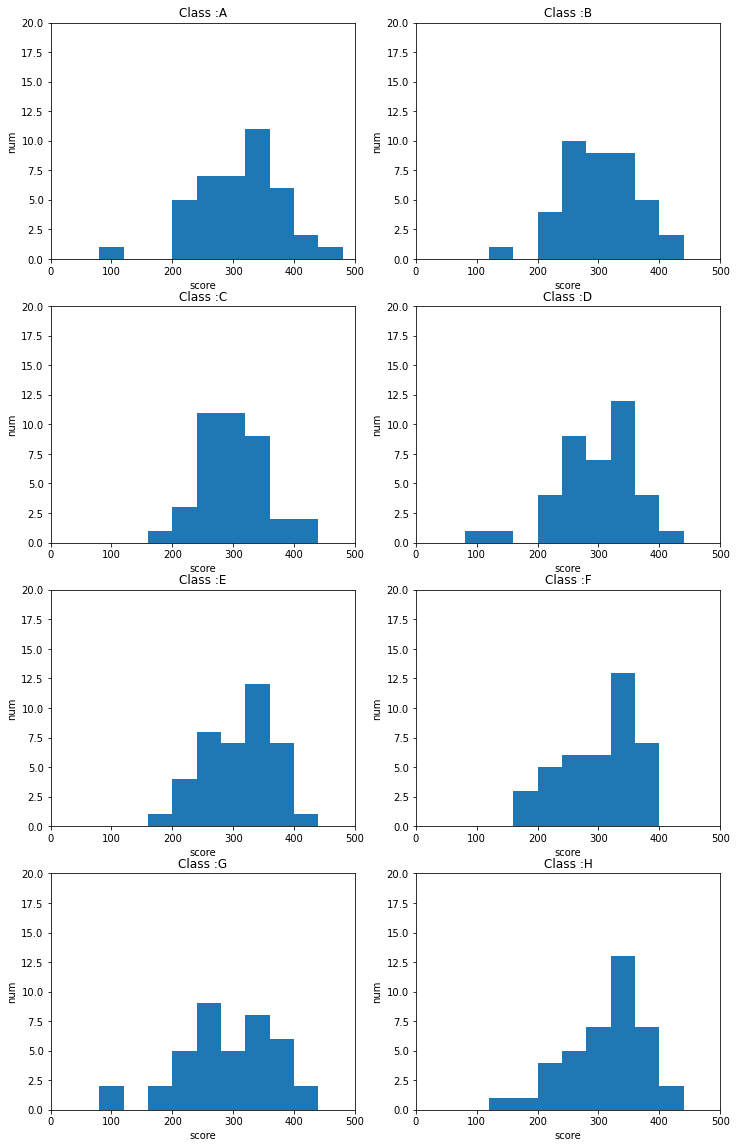

In [95]:
fig = plt.figure(figsize=(12,20))
for i, c in enumerate(C):
    cls_df = result_df[result_df['assigned_class']==c]
    ax = fig.add_subplot(4
                        , 2
                        , i+1
                        , xlabel='score'
                        , ylabel='num'
                        , xlim=(0,500)
                        , ylim=(0,20)
                        , title=f'Class :{c}'
                        )
    ax.hist(cls_df['score'], bins=range(0,500,40))